In [1]:
%pylab inline
from astropy.io import ascii, fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
import sys

Populating the interactive namespace from numpy and matplotlib


In [2]:
comap = fits.open("ico.fits")
comapdata = comap[0].data[0,0]
#size (x,y) of the CO map data array
lencox, lencoy = comapdata.shape
#Filtering -- here we filter out n}ns and any value less than "thresh"
thresh = 0
mask = np.isnan(comapdata) | (comapdata<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
comapdata[mask] = nan
#Get the world coordinates for the CO map
comapheader = comap[0].header
wc = wcs.WCS(comapheader, naxis=2)

In [3]:
wrtab = ascii.read("wr_m33.tsv", data_start=3)
wrcoords = SkyCoord(wrtab["_RA"], wrtab["_DE"], unit="deg")
wrpix = np.asarray(skycoord_to_pixel(wrcoords, wc), dtype=int)
wrpix_insideco = np.array([[i,j] for i,j in wrpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
wrco = comapdata[wrpix_insideco[1], wrpix_insideco[0]]
#Read ASCII table
rsgtab = ascii.read("rsg_m33.tsv", data_start=3)
#Get sky coordinates of RSGs
rsgcoords = SkyCoord(rsgtab["RAJ2000"], rsgtab["DEJ2000"], unit=("hourangle", "deg"))
#Convert sky coordinates to pixels using world coordinate system defined earlier
#np.asarray converts the list into a numpy array with data-type "int". Numpy arrays
#are much easier to manipulate than Python lists
rsgpix = np.asarray(skycoord_to_pixel(rsgcoords, wc), dtype=int)
#Only keep RSG pixels that fall inside the CO map area
#This line below uses the list comprehension trickery of Python! Its the equivalent of writing
rsgpix_insideco = np.array([[i,j] for i,j in rsgpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
rsgco = comapdata[rsgpix_insideco[1], rsgpix_insideco[0]]

In [4]:
#Read ASCII table
snrtab = ascii.read("snrs.tsv", data_start=3)
#Get sky coordinates of snrs
snrcoords = SkyCoord(snrtab["RAJ2000"], snrtab["DEJ2000"], unit=("hourangle", "deg"))
#Convert sky coordinates to pixels using world coordinate system defined earlier
#np.asarray converts the list into a numpy array with data-type "int". Numpy arrays
#are much easier to manipulate than Python lists
snrpix = np.asarray(skycoord_to_pixel(snrcoords, wc), dtype=int)
#Only keep SNR pixels that fall inside the CO map area
#This line below uses the list comprehension trickery of Python! Its the equivalent of writing
snrpix_insideco = np.array([[i,j] for i,j in snrpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T

#Get CO intensity values for the SNR pixels
snrco = comapdata[snrpix_insideco[1], snrpix_insideco[0]]

In [5]:
def get_ncr(data, vals):
    """
    Sets nans equal to 0 in both arrays and returns
    the ncr value
    """
    a = np.nan_to_num(data, copy=True, nan=0.0)
    b = np.nan_to_num(vals, copy=True, nan=0.0)
    a2 = np.sort(a)
    return np.array([np.where(a2>=x)[0][0]/len(a2) for x in b])

In [6]:
comap_zeronans = np.nan_to_num(comapdata.flatten(), copy=True, nan=0.0)
sorted_comap_zeronans = np.sort(comap_zeronans)

filter_arr = []

for element in sorted_comap_zeronans:

  if element > 0:
    filter_arr.append(True)
  else:
    filter_arr.append(False)
    
sorted_comap_nozeros = sorted_comap_zeronans[filter_arr]

In [7]:
snrco2 = np.sort(np.nan_to_num(snrco, copy=True, nan=0.0))
ncr_snrco = get_ncr(sorted_comap_nozeros, snrco)
ncr_WR = get_ncr(sorted_comap_nozeros, wrco)
ncr_RSG = get_ncr(sorted_comap_nozeros, rsgco)

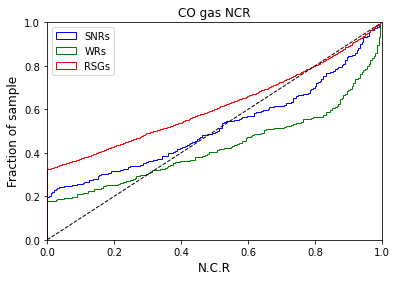

In [8]:
plt.figure()
plt.hist(ncr_snrco, histtype="step", color="blue", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="SNRs")
plt.hist(ncr_WR, histtype="step", color="green", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRs")
plt.hist(ncr_RSG, histtype="step", color="red", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('CO gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()

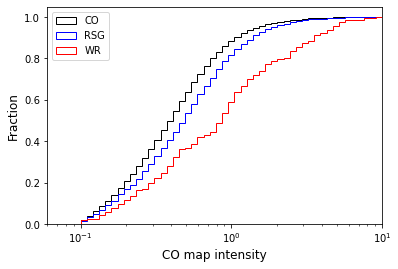

In [9]:
plt.figure()
plt.hist(sorted_comap_nozeros, histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="CO")
plt.hist(rsgco, histtype="step", color="b", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="RSG")
plt.hist(wrco, histtype="step", color="r", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="WR")
plt.xlabel("CO map intensity", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(0.06, 10)
plt.legend(loc=2)
plt.show()

In [10]:
atomicmap = fits.open("atomic.fits")
atomicmapdata = atomicmap[0].data
#size (x,y) of the atomic map data array
lenatomicx, lenatomicy = atomicmapdata.shape
#Filtering -- here we filter out nans and any value less than "thresh"
thresh = 0
mask = np.isnan(atomicmapdata) | (atomicmapdata<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
atomicmapdata[mask] = nan
#Get the world coordinates for the CO map
atomicmapheader = atomicmap[0].header
wc2 = wcs.WCS(atomicmapheader, naxis=2)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [11]:
atomicmap_zeronans = np.nan_to_num(atomicmapdata.flatten(), copy=True, nan=0.0)
sorted_atomicmap_zeronans = np.sort(atomicmap_zeronans)

filter_arr2 = []

for element in sorted_atomicmap_zeronans:

  if element > 0:
    filter_arr2.append(True)
  else:
    filter_arr2.append(False)
    
sorted_atomicmap_nozeros = sorted_atomicmap_zeronans[filter_arr2]

In [12]:
sorted_atomicmap_nozeros

array([1.08726900e-02, 1.54402490e-01, 2.16437474e-01, ...,
       1.24586139e+03, 1.24732097e+03, 1.25031864e+03])

In [13]:
wrpix_insideatomic = np.array([[i,j] for i,j in wrpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
rsgpix_insideatomic = np.array([[i,j] for i,j in rsgpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
snrpix_insideatomic = np.array([[i,j] for i,j in snrpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T

wratomic = atomicmapdata[wrpix_insideatomic[1], wrpix_insideatomic[0]]
rsgatomic = atomicmapdata[rsgpix_insideatomic[1], rsgpix_insideatomic[0]]
snratomic = atomicmapdata[snrpix_insideatomic[1], snrpix_insideatomic[0]]

#Getting NCR
ncr_WRatomic = get_ncr(sorted_atomicmap_nozeros, wratomic)
ncr_RSGatomic = get_ncr(sorted_atomicmap_nozeros, rsgatomic)
ncr_snratomic = get_ncr(sorted_atomicmap_nozeros, snratomic)


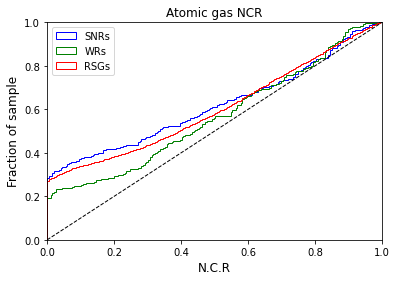

In [14]:
plt.figure()
plt.hist(ncr_snratomic, histtype="step", color="blue", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="SNRs")
plt.hist(ncr_WRatomic, histtype="step", color="green", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRs")
plt.hist(ncr_RSGatomic, histtype="step", color="red", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('Atomic gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()

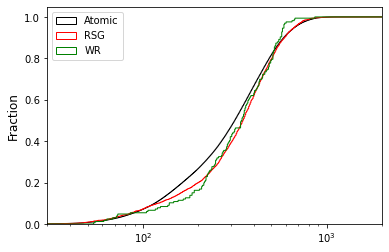

In [15]:
plt.figure()
plt.hist(sorted_atomicmap_nozeros, histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="Atomic")
plt.hist(rsgatomic, histtype="step", color="red", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="RSG")
plt.hist(wratomic, histtype="step", color="green", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="WR")
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(30, 2000)
plt.legend(loc=2)
plt.show()